In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
df = pd.read_csv('cleanedData.csv', low_memory=False)

In [4]:
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df.sample(3)

,Body Type,Driven(KM),No of Owner,Brand(Model),Variant Name,Price(Lakhs),City,Fuel Type,RTO,Transmission,...,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed(KMPH),Acceleration,No Door Numbers,Cargo Volumn,Wheel Size,Age(Months)
4167,Hatchback,79000.0,2,Volkswagen Polo,1.5 TDI Highline,3.33,Delhi,Diesel,DL8C,Manual,...,Power,4.97,Disc,Drum,163.0,16.10,5.0,280.0,15.0,10.0
5608,Hatchback,80000.0,2,Maruti Wagon R,LXI CNG,2.60,Hyderabad,CNG,AP10,Manual,...,Power,4.60,Ventilated Disc,Drum,NaN,NaN,4.0,NaN,13.0,12.0
1240,Hatchback,55127.0,1,Maruti Baleno,1.2 CVT Delta,6.43,Bangalore,Petrol,KA03,Automatic,...,Power,4.90,Disc,Drum,180.0,12.79,5.0,339.0,NaN,7.0


In [5]:
# SPLITTING TRAINING AND TESTING DATA

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

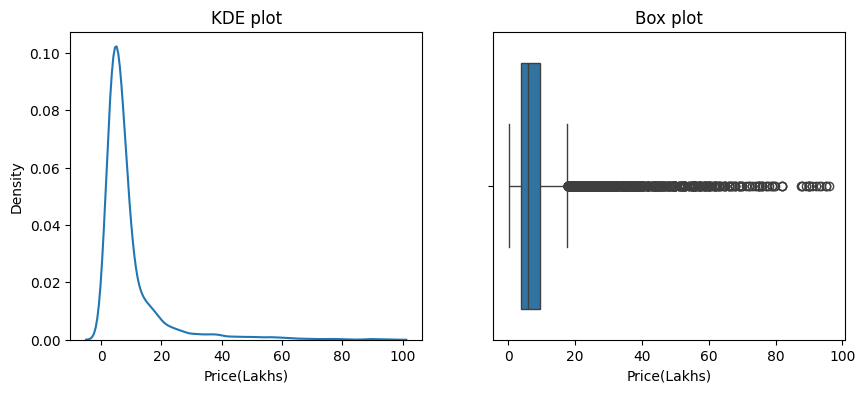

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

sns.kdeplot(data = df, x='Price(Lakhs)', ax=ax[0])
ax[0].set_title('KDE plot')

sns.boxplot(data = df, x='Price(Lakhs)', ax=ax[1])
ax[1].set_title('Box plot')

plt.show()

In [8]:
# Target Column has Outliers. So, the log transformer has to be used.

In [497]:
X = df.drop(columns=['Price(Lakhs)'])
y = df['Price(Lakhs)']

In [498]:
y_log = np.log(y)

In [499]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((6695, 54), (1674, 54))

In [500]:
# The columns with more than 80% same values has no proper contribution to the model.
# So, the columns have to be dropped

In [501]:
# The columns with more than 80% same values has no proper contribution to the model.
# So, the columns have to be dropped

X_train_same_value_threshold = 0.8
X_train_same_value_drop_list = [col for col in X_train.columns if X_train[col].value_counts(normalize=True).values[0] > X_train_same_value_threshold]
X_train_same_value_drop_list

['Steering',
 'Front',
 'Lights',
 'Rear',
 'Opener',
 'Beams',
 'Bag',
 'Seats',
 'Drive Type']

In [502]:
X_train = X_train.drop(columns=X_train_same_value_drop_list, axis=1)
X_test = X_test.drop(columns=X_train_same_value_drop_list, axis=1)

In [503]:
# The columns with more than 50% missing values have no proper contribution to the model.
# So, the columns have to be dropped

In [504]:
# The columns with more than 50% missing values have no proper contribution to the model.
# So, the columns have to be dropped

X_train_missing_value_threshold = 0.5
X_train_missing_value_drop_list = [col for col in X_train.columns if X_train[col].isna().mean() > X_train_missing_value_threshold]
X_train_missing_value_drop_list

[]

In [505]:
# IMPUTING MISSING VALUES

In [506]:
num_col_list = X_train.select_dtypes(include=['float64']).columns.to_list()

In [507]:
# Filling missing values with the KNNImputing method
kimputer = KNNImputer(weights='distance')

X_train[num_col_list] = kimputer.fit_transform(X_train[num_col_list])
X_test[num_col_list] = kimputer.transform(X_test[num_col_list])

In [508]:
cat_col_list = X_train.select_dtypes(include=['object']).columns.to_list()

In [509]:
for col in cat_col_list:
    X_train.loc[X_train[col].isna(), col] = X_train[col].dropna().sample(X_train[col].isna().sum()).values
    X_test.loc[X_test[col].isna(), col] = X_train[col].dropna().sample(X_test[col].isna().sum()).values

In [510]:
# DETECTING AND CAPPING OUTLIERS

In [511]:
for col in num_col_list:

    # Quantiles range calculation
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)

    # Inter Quartile Range calculation
    IQR = Q3 - Q1

    # Minimum and Maximum values calculations for outliers
    lower_value = Q1 - 1.5 * IQR
    upper_value = Q3 + 1.5 * IQR

    # Capping outliers with the max and min values for Training data
    X_train.loc[X_train[col] > upper_value, col] = upper_value
    X_train.loc[X_train[col] < lower_value, col] = lower_value

    # Capping outliers with the max and min values for Testing data
    X_test.loc[X_test[col] > upper_value, col] = upper_value
    X_test.loc[X_test[col] < lower_value, col] = lower_value

In [512]:
# CORRELATION ANALYSIS 

In [513]:
corr_matrix = pd.concat([X_train[num_col_list], y_train_log], axis=1).corr().abs()

In [514]:
# plt.figure(figsize=(20,18))
# sns.heatmap(corr_matrix, annot=True)

In [515]:
threshold = 0.8

# Find columns that are highly correlated
high_corr_pairs = np.where(corr_matrix > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]
high_corr_pairs

[('Max Power', 'Torque'),
 ('Max Power', 'Displacement'),
 ('Max Power', 'Length(mm)'),
 ('Max Power', 'Width(mm)'),
 ('Max Power', 'Wheel Base(mm)'),
 ('Max Power', 'Kerb Weight(KG)'),
 ('Max Power', 'Turning Radius'),
 ('Max Power', 'Top Speed(KMPH)'),
 ('Max Power', 'Acceleration'),
 ('Max Power', 'Wheel Size'),
 ('Torque', 'Displacement'),
 ('Torque', 'Kerb Weight(KG)'),
 ('Displacement', 'Kerb Weight(KG)'),
 ('Displacement', 'Turning Radius'),
 ('Length(mm)', 'Width(mm)'),
 ('Length(mm)', 'Wheel Base(mm)'),
 ('Length(mm)', 'Turning Radius'),
 ('Width(mm)', 'Wheel Base(mm)'),
 ('Width(mm)', 'Front Tread'),
 ('Width(mm)', 'Rear Tread'),
 ('Width(mm)', 'Wheel Size'),
 ('Wheel Base(mm)', 'Turning Radius'),
 ('Front Tread', 'Rear Tread'),
 ('Kerb Weight(KG)', 'Turning Radius'),
 ('Top Speed(KMPH)', 'Acceleration')]

In [516]:
# By observing the above highly correlating columns have to be dropped.
# No of Cylinder and No Door Number columns not relating to the Target column. So, the columns have to be dropped. 

In [517]:
cols_drop_list = ['Turning Radius', 'Kerb Weight(KG)', 'Front Tread', 'Rear Tread', 'Wheel Size', 
                  'No Door Numbers', 'No of Cylinder', 'Wheel Base(mm)']
X_train = X_train.drop(columns = cols_drop_list, axis=1)
X_test = X_test.drop(columns = cols_drop_list, axis=1)

In [518]:
X_train['Area'] = 2 * (X_train['Length(mm)'] + X_train['Width(mm)'])
X_test['Area'] = 2 * (X_test['Length(mm)'] + X_test['Width(mm)'])

In [519]:
X_train = X_train.drop(columns = ['Length(mm)', 'Width(mm)'], axis=1)
X_test = X_test.drop(columns = ['Length(mm)', 'Width(mm)'], axis=1)

In [520]:
def replacestr(value):
    if value == 'YES':
        return value.replace('ES', 'es')
    elif value == 'NO':
        return value.replace('O', 'o')
    elif value == 'yes':
        return value.replace('y', 'Y')
    elif value == 'no':
        return value.replace('n', 'N')
    else:
        return value

X_train['Turbo Charger'] = X_train['Turbo Charger'].apply(replacestr)

In [521]:
cat_cols_drop_list = ['Front Brake Type', 'Rear Brake Type']

In [522]:
# By domain knowledge, the above categorical columns will not affect the price much. So, the columns have to be dropped.

In [523]:
X_train = X_train.drop(columns = cat_cols_drop_list, axis=1)
X_test = X_test.drop(columns = cat_cols_drop_list, axis=1)

In [524]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [525]:
# SCALING THE NUMERICAL COLUMNS

In [526]:
scaling_list = X_train.select_dtypes(include=['float64']).columns.to_list()

scaler = StandardScaler()
X_train[scaling_list] = scaler.fit_transform(X_train[scaling_list])
X_test[scaling_list] = scaler.transform(X_test[scaling_list])

In [527]:
# ENCODING THE CATEGORICAL COLUMNS

In [528]:
target_en_cols = ['Brand(Model)', 'Variant Name', 'RTO', 'Color', 'Engine Type', 'Fuel Suppy System']
for col in target_en_cols:
    mean_target = df.groupby(col)['Price(Lakhs)'].mean()
    X_train[col] = X_train[col].map(mean_target)
    X_test[col] = X_test[col].map(mean_target)

In [529]:
# X_train = X_train[['Body Type','Fuel Type', 'Transmission', 'Value Configuration']]
# X_test = X_test[['Body Type','Fuel Type', 'Transmission', 'Value Configuration']]

In [530]:
ohe_en_cols = ['Body Type', 'Fuel Type', 'Transmission', 'City', 'Value Configuration', 'Light', 'Headrest', 'Antenna', 'Headlamps', 'System', 
               'Wheel', 'Control', 'Warning', 'Turbo Charger', 'Steering Type']

In [531]:
ohencoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_encoded = ohencoder.fit_transform(X_train[ohe_en_cols])
X_test_encoded = ohencoder.transform(X_test[ohe_en_cols])

encoded_columns = ohencoder.get_feature_names_out(ohe_en_cols)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

X_train = pd.concat([X_train.drop(ohe_en_cols, axis=1), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(ohe_en_cols, axis=1), X_test_encoded_df], axis=1)

C:\Users\HP\Documents\Python\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 13, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [532]:
X_train.sample(5)

,Driven(KM),No of Owner,Brand(Model),Variant Name,RTO,Mileage(KM),Max Power,Torque,Color,Engine Type,...,Turbo Charger_Turbo,Turbo Charger_Twin,Turbo Charger_Yes,Steering Type_Electric,Steering Type_Electrical,Steering Type_Electronic,Steering Type_Hydraulic,Steering Type_Manual,Steering Type_Power,Steering Type_power
5196,-1.113949,1,6.442644,7.445000,7.334615,0.913675,-0.372427,-0.626743,12.301752,8.299091,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4288,-1.025790,1,16.868125,16.255238,9.428000,-1.465638,1.080757,0.845313,7.291805,3.840526,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1834,0.002732,1,23.640455,47.000000,8.309459,-2.475215,2.160958,2.134705,11.659785,26.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6091,1.236958,2,3.444545,1.683333,10.461894,-2.049831,1.163796,-1.626021,6.749451,4.762624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3408,-0.671391,1,49.551818,59.948333,26.745000,-0.530633,2.160958,2.161567,12.301752,59.948333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [533]:
# MACHINE LEARNING MODELS

In [534]:
# LINEAR REGRESSION

In [535]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [536]:
lr = LinearRegression()
lr.fit(X_train, y_train_log)

LinearRegression()

In [537]:
y_pred_log = lr.predict(X_test)
y_train_pred_log = lr.predict(X_train)

In [538]:
y_pred = np.exp(y_pred_log)
y_test = np.exp(y_test_log)
y_train_pred = np.exp(y_train_pred_log)
y_train = np.exp(y_train_log)

In [539]:
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 Score: ', r2_score(y_test, y_pred))

MAE:  2.00835329428221
MSE:  64.43143673979085
R2 Score:  0.5233424850630395


In [540]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_test, y_pred), end='\n')

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_pred))

34.54067528236807
64.43143673979085
0.6771907127774017
0.5233424850630395


In [541]:
# coefficients = lr.coef_
# features = X_train.columns
# feature_importances = pd.DataFrame({'Feature': features, 'Importance': coefficients})

# feature_importances['Absolute Importance'] = feature_importances['Importance'].abs()
# feature_importances = feature_importances.sort_values(by='Absolute Importance', ascending=False)

# # Display feature importances
# print(feature_importances['Feature'].values)

In [542]:
# LASSO REGRESSION 

In [543]:
# The linear regression model seems to be underfitting. So, the lasso regression has to apply. 

In [544]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train_log)
y_lasso_pred_log = lasso.predict(X_test)
y_train_lasso_pred_log = lasso.predict(X_train)

In [545]:
y_lasso_pred = np.exp(y_lasso_pred_log)
y_train_lasso_pred = np.exp(y_train_lasso_pred_log)
y_test = np.exp(y_test_log)

In [546]:
print('MAE: ', mean_absolute_error(y_test, y_lasso_pred))
print('MSE: ', mean_squared_error(y_test, y_lasso_pred))
print('R2 Score: ', r2_score(y_test, y_lasso_pred))

MAE:  1.9701543953022969
MSE:  54.4962433268501
R2 Score:  0.5968420815683242


In [547]:
print(mean_squared_error(y_train, y_train_lasso_pred))
print(mean_squared_error(y_test, y_lasso_pred))

print(r2_score(y_train, y_train_lasso_pred))
print(r2_score(y_test, y_lasso_pred))

30.167317098836644
54.4962433268501
0.718063122666723
0.5968420815683242


In [548]:
cat_cols = ['Light', 'Headrest', 'Antenna', 'Headlamps', 'System', 'Variant Name', 'RTO', 'Engine Type', 'Fuel Suppy System', 
            'Wheel', 'Control', 'Warning', 'Turbo Charger', 'Steering Type', 'Color', 'Value Configuration', 'Body Type', 'City']
num_cols = ['Mileage', 'Torque', 'Displacement', 'Acceleration', 'Cargo Volumn', 'No of Owner', 'Top Speed', 'Height']

In [549]:
cat_pattern = '|'.join(cat_cols)
num_pattern = '|'.join(num_cols)

X_train = X_train.drop(X_train.filter(regex=cat_pattern).columns, axis=1)
X_test = X_test.drop(X_test.filter(regex=cat_pattern).columns, axis=1)

X_train = X_train.drop(X_train.filter(regex=num_pattern).columns, axis=1)
X_test = X_test.drop(X_test.filter(regex=num_pattern).columns, axis=1)


In [551]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train_log)

LinearRegression()

In [552]:
y_pred_log = lr1.predict(X_test)
y_train_pred_log = lr1.predict(X_train)

In [553]:
y_pred = np.exp(y_pred_log)
y_test = np.exp(y_test_log)
y_train_pred = np.exp(y_train_pred_log)
y_train = np.exp(y_train_log)

In [554]:
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 Score: ', r2_score(y_test, y_pred))

MAE:  2.0560978441758664
MSE:  27.515696309235683
R2 Score:  0.7964415495266984


In [555]:
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_test, y_pred), end='\n')

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_pred))

20.4129436705903
27.515696309235683
0.8092252759232524
0.7964415495266984
